# Obtención y merjoramiento de la imagen

## carga de archivos


In [87]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal
import math
import os
import pandas as pd
import SimpleITK as sitk
import cv2

In [88]:
#from google.colab import drive
#drive.mount('/content/drive')


In [113]:

# aca pongan el path a su carpeta de imagenes del drive
test_image_dir = 'C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP imagenes/Dataset/test/images'

train_image_dir = 'C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP imagenes/Dataset/train/images'
train_labels_dir = 'C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP imagenes/Dataset/train/labels'
# me armo una lista
test_image_files = [f for f in os.listdir(test_image_dir) if os.path.isfile(os.path.join(test_image_dir, f))]

train_image_files = [f for f in os.listdir(train_image_dir) if os.path.isfile(os.path.join(train_image_dir, f))]
train_labels_files = [f for f in os.listdir(train_labels_dir) if os.path.isfile(os.path.join(train_labels_dir, f))]
# creo un dataframe con las rutas de las imagenes
test_image_paths = pd.DataFrame({'ImagePath': [os.path.join(test_image_dir, f) for f in test_image_files]})

train_image_paths = pd.DataFrame({'ImagePath': [os.path.join(train_image_dir, f) for f in train_image_files]})
train_labels_paths = pd.DataFrame({'LabelPath': [os.path.join(train_labels_dir, f) for f in train_labels_files]})
print(len(test_image_paths))
print(len(train_image_paths))
print(len(train_labels_paths))

                                             ImagePath
0    C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
1    C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
2    C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
3    C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
4    C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
..                                                 ...
118  C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
119  C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
120  C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
121  C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...
122  C:/Users/Juan Bautista/.vscode/PSIB/TPs/TP ima...

[123 rows x 1 columns]
123
1054
1054


In [132]:
# creo un vector vacio para guardar las imagenes
test_images = []
train_images = []
train_labels = []   
# en cada valor guardo una imagen
for path in test_image_paths['ImagePath']:
    # leo en grices
    img = cv2.imread(path, 0)
    test_images.append(img)
for path in train_image_paths['ImagePath']:
    # leo en grices
    img = cv2.imread(path, 0)
    train_images.append(img)
# cantidad de imagenes cargadas
#cargo las labels 
for path in train_labels_paths['LabelPath']:
    # leo los labels
    with open(path, 'r') as file:
        lines = file.read().splitlines()
        separated_values = [line.split() for line in lines]
        # Convierto los valores a float y los guardo en una lista
        numeric_values = [[float(value) for value in line] for line in separated_values]
    train_labels.append(numeric_values)

La lista "labels" contiene informacion sobre las dimensiones de las bounding box de cada calculo renal


In [134]:
print(f"Cantidad total de imagenes de testeo: {len(test_images)}")

print(f"Cantidad total de imagenes de entrenamiento: {len(train_images)}")

print(f"Cantidad total de labels de entrenamiento: {len(train_labels)}")

Cantidad total de imagenes de testeo: 123
Cantidad total de imagenes de entrenamiento: 1054
Cantidad total de labels de entrenamiento: 1054


In [135]:
print(train_labels[0][0])

[0.0, 0.3312020460358056, 0.6359375, 0.0639386189258312, 0.0625]


## Lectura de archivos

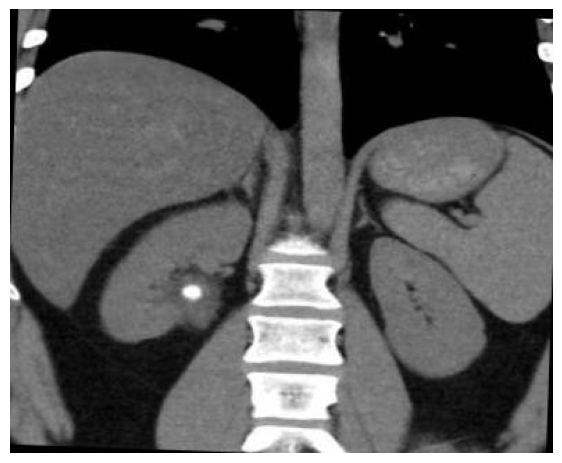

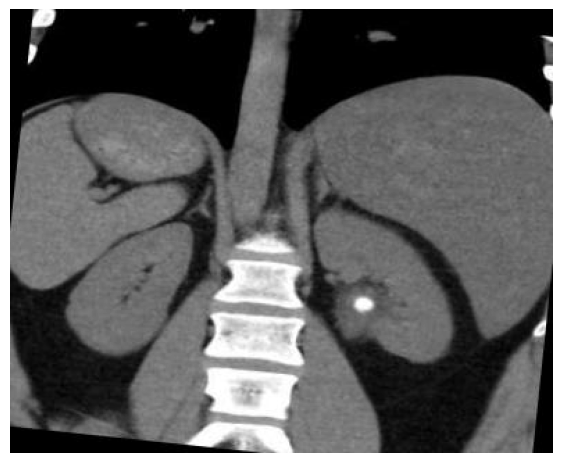

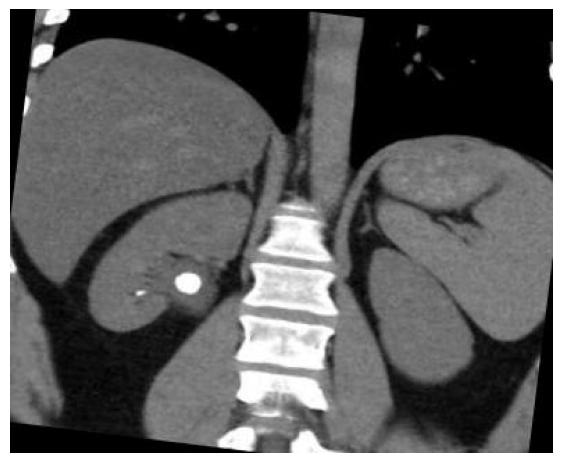

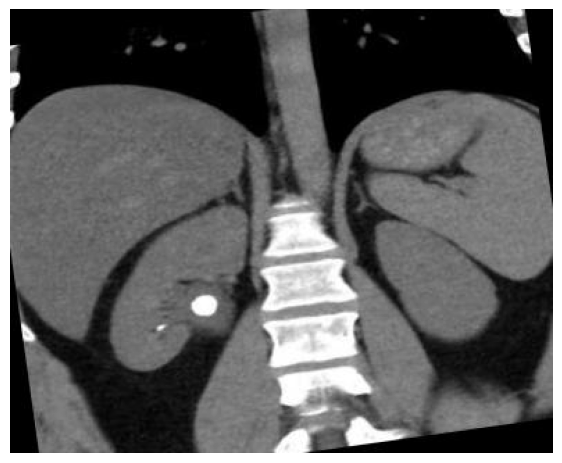

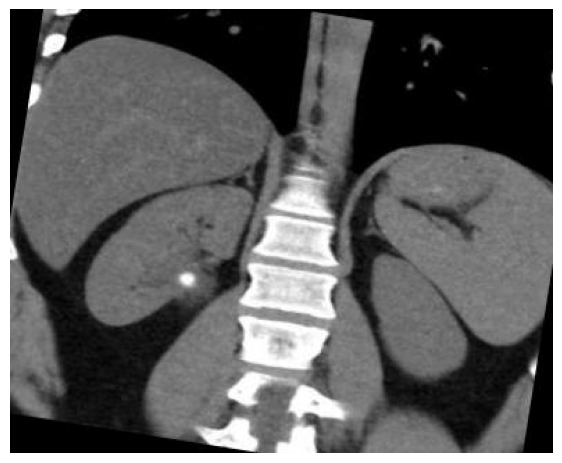

In [92]:
for i in range(0, 5):
    plt.figure(figsize=(7,7))
    plt.imshow(train_images[i], cmap="gray",vmin=0, vmax=255)
    plt.axis(False)
    plt.show()

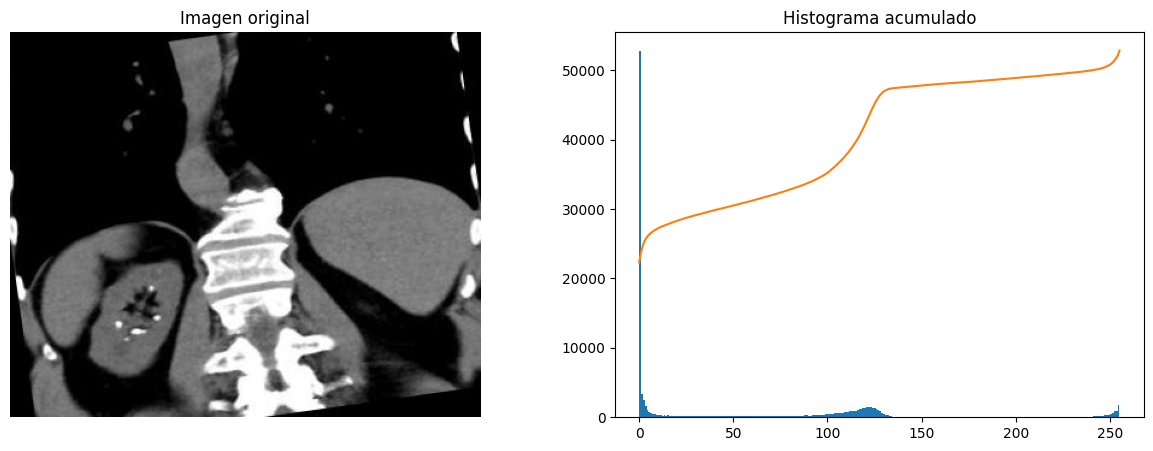

In [93]:
#Generamos histograma

hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img,cmap="gray")
ax[0].axis(False)
ax[0].set_title("Imagen original")

ax[1].hist(np.ravel(img), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma acumulado")
plt.show()


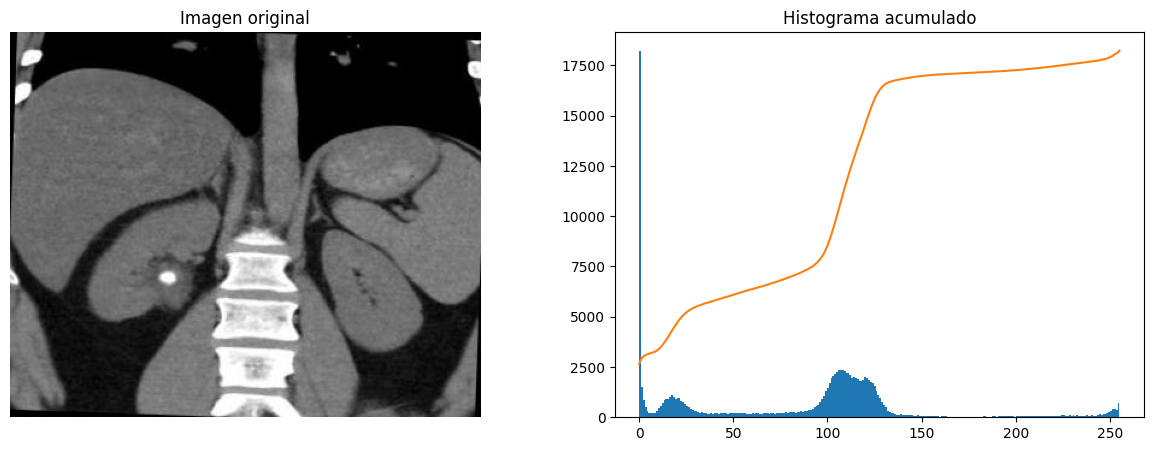

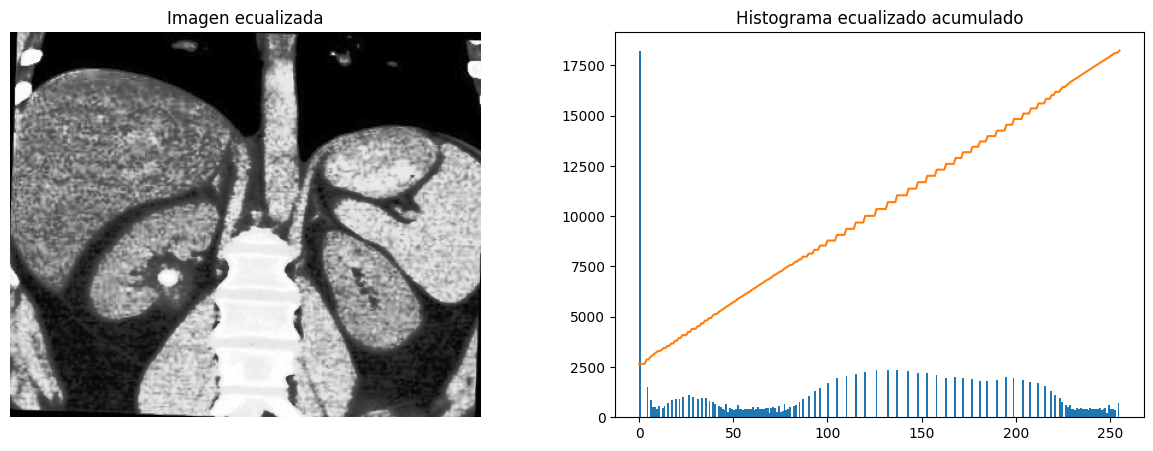

In [94]:
#Ecualizamos
img = train_images[0]
img_ec = cv2.equalizeHist(img)
hist,bins = np.histogram(img.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img,cmap="gray")
ax[0].axis(False)
ax[0].set_title("Imagen original")

ax[1].hist(np.ravel(img), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma acumulado")
plt.show()

hist,bins = np.histogram(img_ec.flatten(),256,[0,256])
cdf = hist.cumsum()#acumulado
cdf_normalized = cdf *hist.max() / cdf.max()#lo normalizo
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(img_ec,vmin=0, vmax=255,cmap='gray')
ax[0].set_title('Imagen ecualizada')
ax[0].axis(False)
ax[1].hist(np.ravel(img_ec), bins=256, range=(0,255))
ax[1].plot(cdf_normalized)
ax[1].set_title("Histograma ecualizado acumulado")
plt.show()

## Binarizacion

Para encontrar el calculo y poder segmentarlo, primeramente hay que **binarizar la imagen**. Para ello, conviene aplicar alguno de los metodos de umbralizado, como Otsu. Sin embargo, este último actua mejor sobre histogramas bimodales, por lo que la ecualización de la imagen no es útil en este caso.

110.0


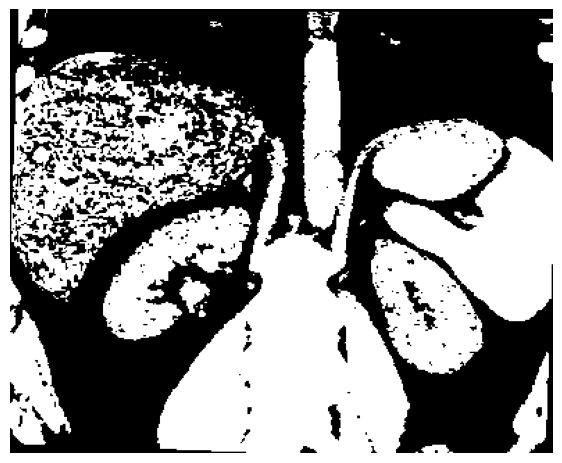

In [95]:
umbral, img_otsu = cv2.threshold(img_ec, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(umbral)
plt.figure(figsize=(7,7))
plt.imshow(img_otsu, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()

Vemos que por *Otsu* el resultado no es óptimo, dado que el histograma no es bimodal y hay presencia de grices cercanos a la región de interés. Por ende, no conviene realizar la binarización por este método. Lo ideal para sacar las regiones de gris cercanas al cálculo renal es clusterizarlas y binarizar luego.

In [96]:
def kmeans(imagen,k, iteraciones,epsilon):
  copia=imagen.copy()
  pixel_vals = copia.reshape((-1))#se pasa la dimensión de la imagen a no--> NO IMPORTA LA DISTRIBUCIÓN ESPACIAL
  pixel_vals = np.float32(pixel_vals)#El algoritmos nos pide floats de 32 bits
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, iteraciones, epsilon) #se para el algoritmo cuando se haya cumplido el epsilon o cuando se hayan acabado las iteraciones,cada attemp itera n veces, epsilon (precision)

  flags = cv2.KMEANS_RANDOM_CENTERS #situa los centroides inicales

  compactness, labels, centers = cv2.kmeans(pixel_vals, 3, None, criteria, 10, flags)

  center = np.uint8(centers)

  img_1_kmeans = center[labels.flatten()] #Asigna a cada píxel el valor del centro del cluster al que pertenece
  img_1_kmeans = img_1_kmeans.reshape((copia.shape))
  centers=centers.flatten()
  return img_1_kmeans, centers



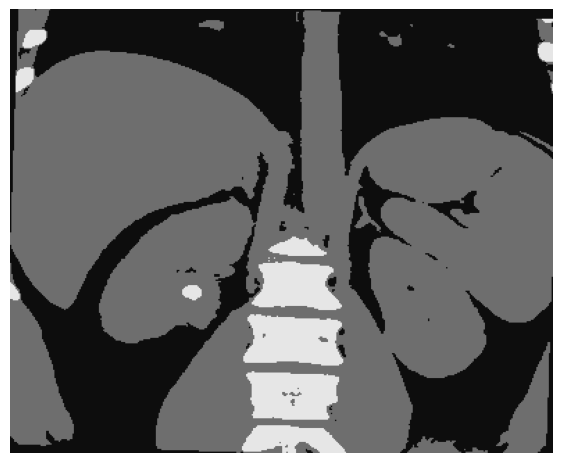

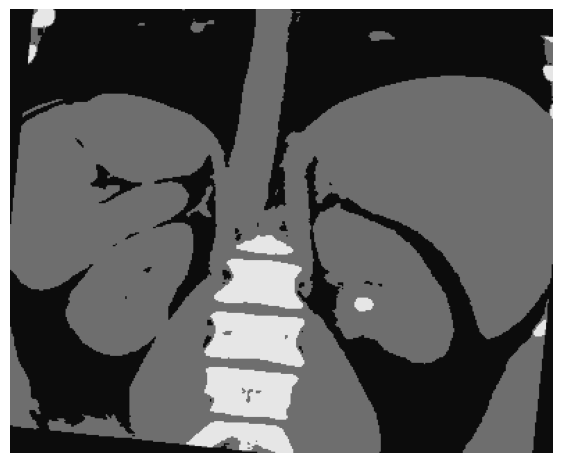

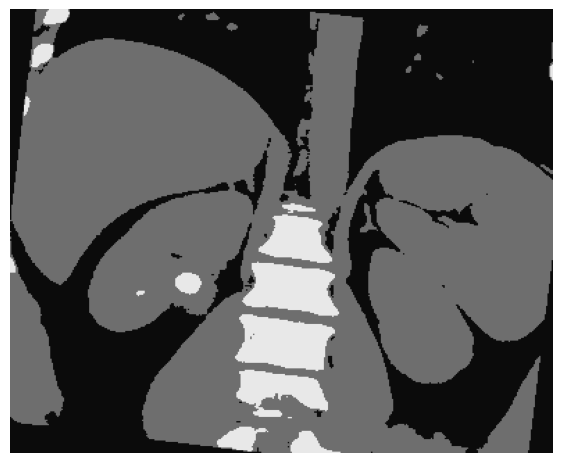

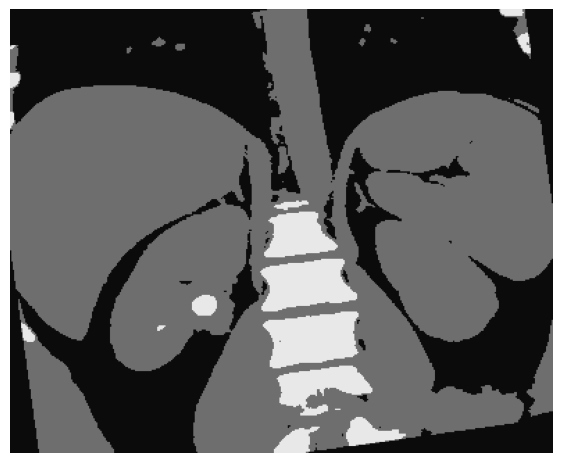

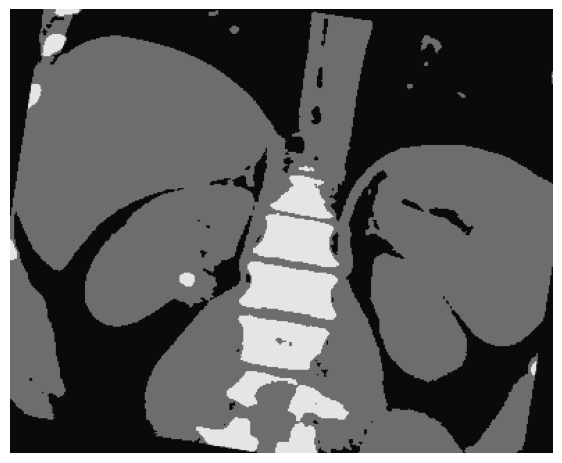

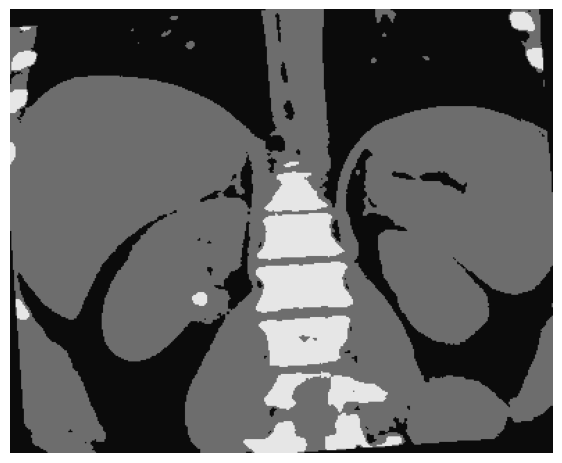

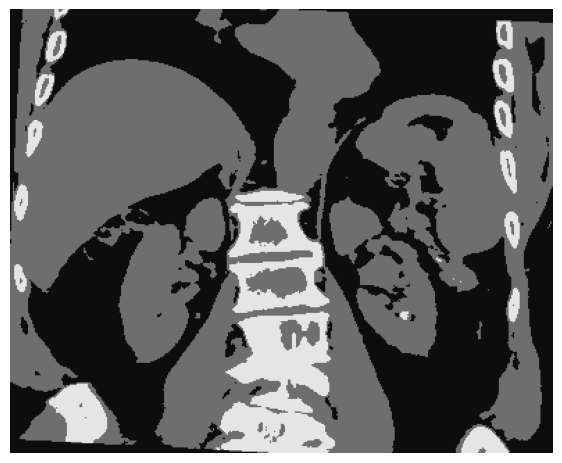

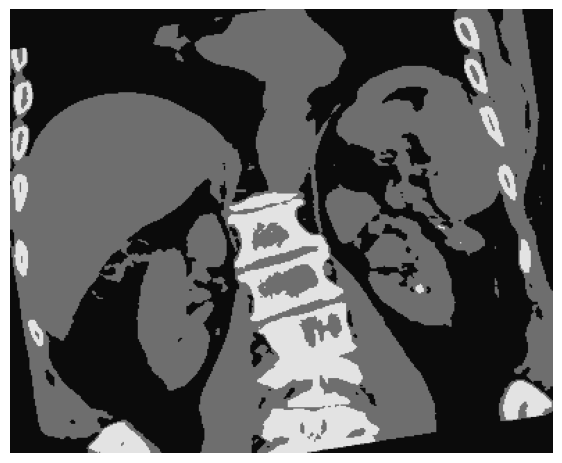

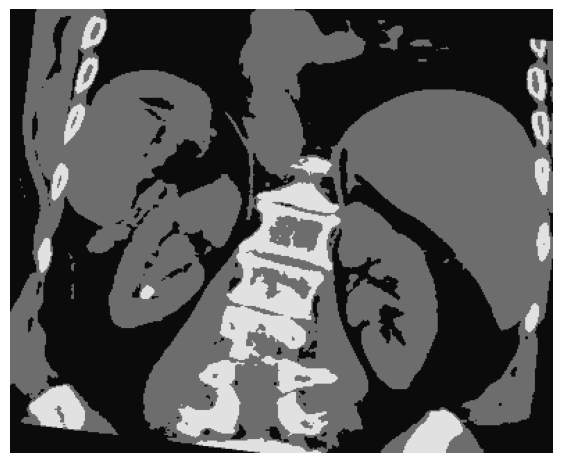

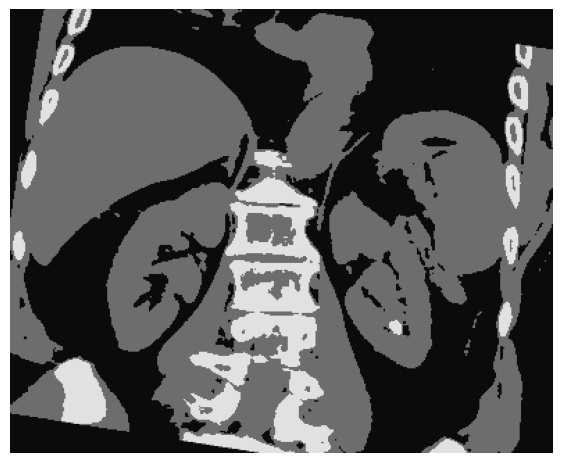

In [105]:
for i in range(0, 10):
  img=train_images[i]
  img_kmeans,_=kmeans(img,3,10,0.9)
  plt.figure(figsize=(7,7))
  plt.imshow(img_kmeans, cmap="gray",vmin=0, vmax=255)
  plt.axis(False)
  plt.show()

[230.78252  110.17889   13.266648]


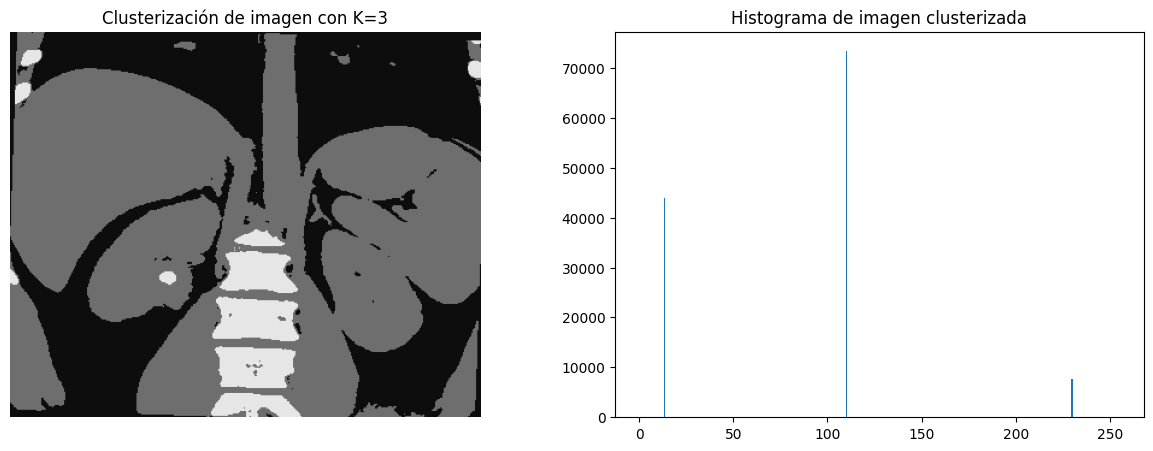

In [106]:
img=train_images[0]
img_cluster, centros=kmeans(img,3,10,0.9)
fig,ax = plt.subplots(1,2,figsize=(15,5))
print(centros)

ax[0].imshow(img_cluster, cmap="gray",vmin=0, vmax=255)
ax[0].set_title("Clusterización de imagen con K=3")
ax[0].axis(False)
ax[1].hist(np.ravel(img_cluster), bins=256, range=(0,255))
ax[1].set_title("Histograma de imagen clusterizada")
plt.show()

In [107]:
def binarizar(img_clust, centros):
  umb, img_bin = cv2.threshold(img_clust, max(centros)-10, 255, cv2.THRESH_BINARY)
  return umb, img_bin

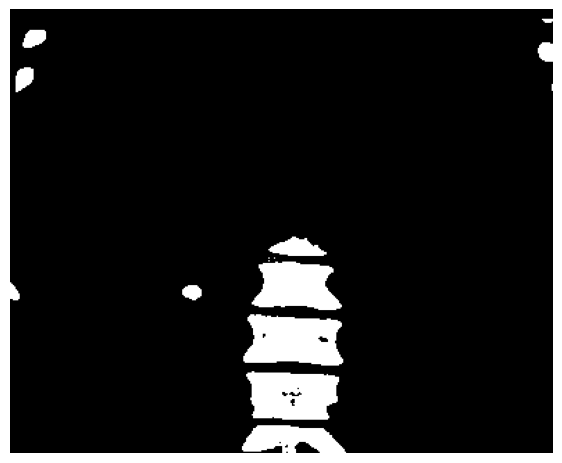

In [108]:
imgbin=binarizar(img_cluster,centros)[1]
plt.figure(figsize=(7,7))
plt.imshow(imgbin, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()

In [109]:
ret, labels = cv2.connectedComponents(imgbin)#ret es la cantidad de etiquetas y labels la matriz de la imagen etiquetada
ret


16

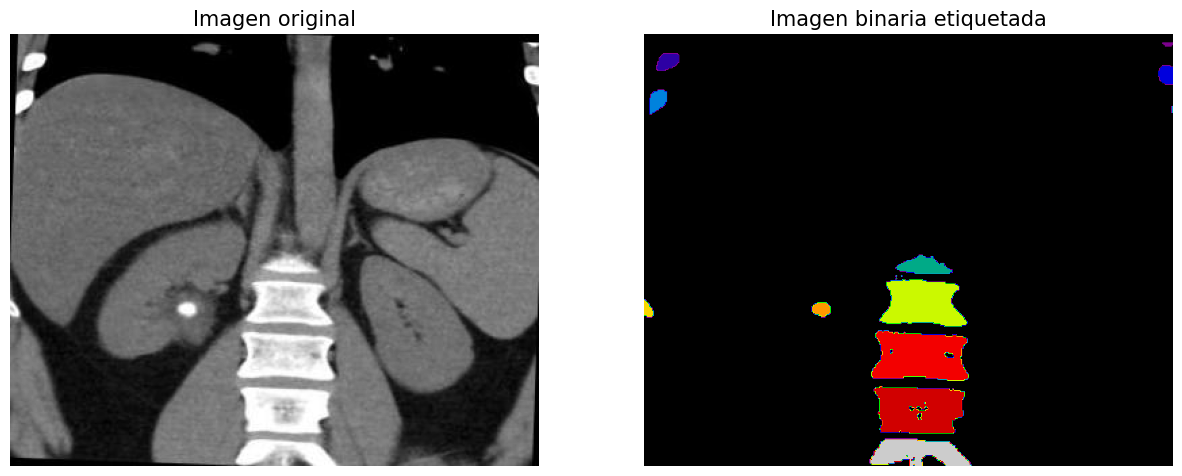

In [110]:
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('Imagen original',fontsize=15)
plt.axis(False)
plt.subplot(122)
plt.imshow(labels, cmap='nipy_spectral')
plt.title('Imagen binaria etiquetada',fontsize=15)
plt.axis(False)
plt.show()

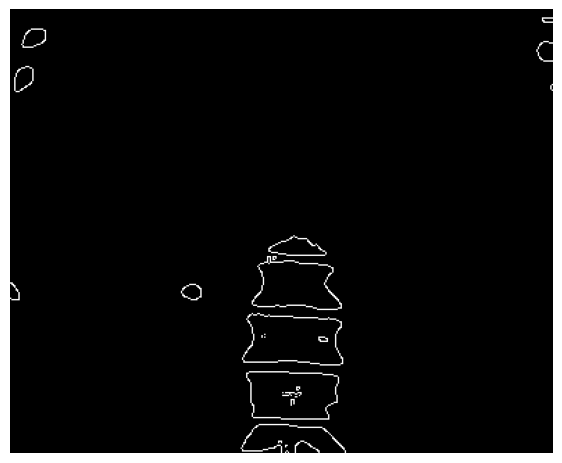

In [111]:
img_Canny = cv2.Canny(imgbin, 200, 256)
plt.figure(figsize=(7,7))
plt.imshow(img_Canny, cmap="gray",vmin=0, vmax=255)
plt.axis(False)
plt.show()

## Bounding Boxes

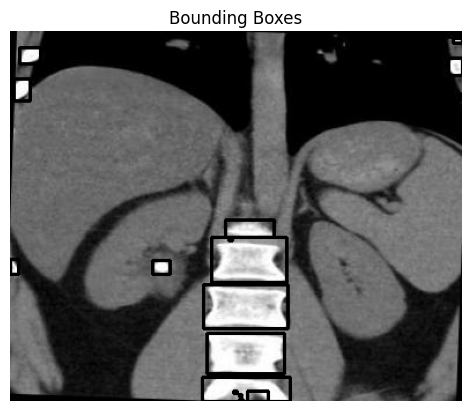

In [112]:

# Find contours
contours, _ = cv2.findContours(img_Canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Display the result
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Bounding Boxes')
plt.axis('off')
plt.show()

In [136]:
def Boxes(img):
    img_cluster, centros=kmeans(img,3,10,0.9)
    imgbin=binarizar(img_cluster,centros)[1]
    img_Canny = cv2.Canny(imgbin, 200, 256)
    contours, _ = cv2.findContours(img_Canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Bounding Boxes')
    plt.axis('off')
    plt.show()

Esta bien, marcamos las bounding boxes y claramente toma el calculo. Pero, como nos deshacemos del resto de cajas. El primer aproach va a ser generar valores promedios que nos permitan determinar si se trata de un calculo o no